In [1]:
import dask.dataframe as dd
import dask.array as da
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [2]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.34 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57816,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.34 GiB
Comm: tcp://127.0.0.1:57835,Total threads: 4
Dashboard: http://127.0.0.1:57839/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:57819,


2024-11-23 09:58:02,550 - distributed.scheduler - WARNING - Worker failed to heartbeat for 43199s; attempting restart: <WorkerState 'tcp://127.0.0.1:57836', name: 2, status: running, memory: 0, processing: 0>
2024-11-23 09:58:02,791 - distributed.scheduler - WARNING - Worker failed to heartbeat for 43199s; attempting restart: <WorkerState 'tcp://127.0.0.1:57837', name: 1, status: running, memory: 0, processing: 0>
2024-11-23 09:58:02,795 - distributed.scheduler - WARNING - Worker failed to heartbeat for 43199s; attempting restart: <WorkerState 'tcp://127.0.0.1:57838', name: 3, status: running, memory: 0, processing: 0>
2024-11-23 09:58:06,231 - distributed.nanny - WARNING - Restarting worker
2024-11-23 09:58:06,296 - distributed.nanny - WARNING - Restarting worker
2024-11-23 09:58:06,457 - distributed.nanny - WARNING - Restarting worker
2024-11-23 10:43:19,558 - distributed.scheduler - WARNING - Worker failed to heartbeat for 2707s; attempting restart: <WorkerState 'tcp://127.0.0.1:578

In [3]:
#Load PHAGE METADATA in a dask dataframe

# Path to the folder containing TSV files -> PROTEIN METADATA
folder_path = r'C:\Users\lorenzo\Desktop\phagescope\Metadata\phage_metadata\*.tsv'  # Use a wildcard to select all TSV files
folder_path = folder_path.replace(os.sep, '/')
# Load all TSV files into a single Dask DataFrame
#start = time.time()
phage_metadata = dd.read_csv(folder_path, sep='\t')

#print("elapsed time: " +  str(time.time() - start))

# Optionally, print the first few rows (this won't trigger computation yet)
phage_metadata.head()



,Phage_ID,Length,GC_content,Taxonomy,Completeness,Host,Lifestyle,Cluster,Subcluster,Phage_source
0,SRS101376_a1_ct99314_vs01,31763,50.511602,Myoviridae,High-quality,Gemmiger,virulent,cluster_33392,subcluster_40629,CHVD
1,SRS101388_a1_ct42327_vs01,223331,42.421339,Myoviridae,High-quality,Neisseria,virulent,cluster_340704,subcluster_411447,CHVD
2,SRS101376_a1_ct26874_vs01,25835,52.897232,Myoviridae,Low-quality,-,virulent,cluster_208857,subcluster_251798,CHVD
3,SAMEA1906416_a1_ct13001,53468,40.515823,Siphoviridae,High-quality,Lachnospiraceae,virulent,cluster_243648,subcluster_294650,CHVD
4,SAMEA1906416_a1_ct130485_vs1,23523,61.658802,Siphoviridae,Medium-quality,Bifidobacterium,virulent,cluster_44056,subcluster_53753,CHVD


In [4]:
# Split the "Host" column into multiple rows
split_df = phage_metadata['Host'].str.split(';').explode()

# Remove any empty strings that might result from splitting
split_df = split_df[split_df != '']

data = split_df.compute()

data = data.astype('string')

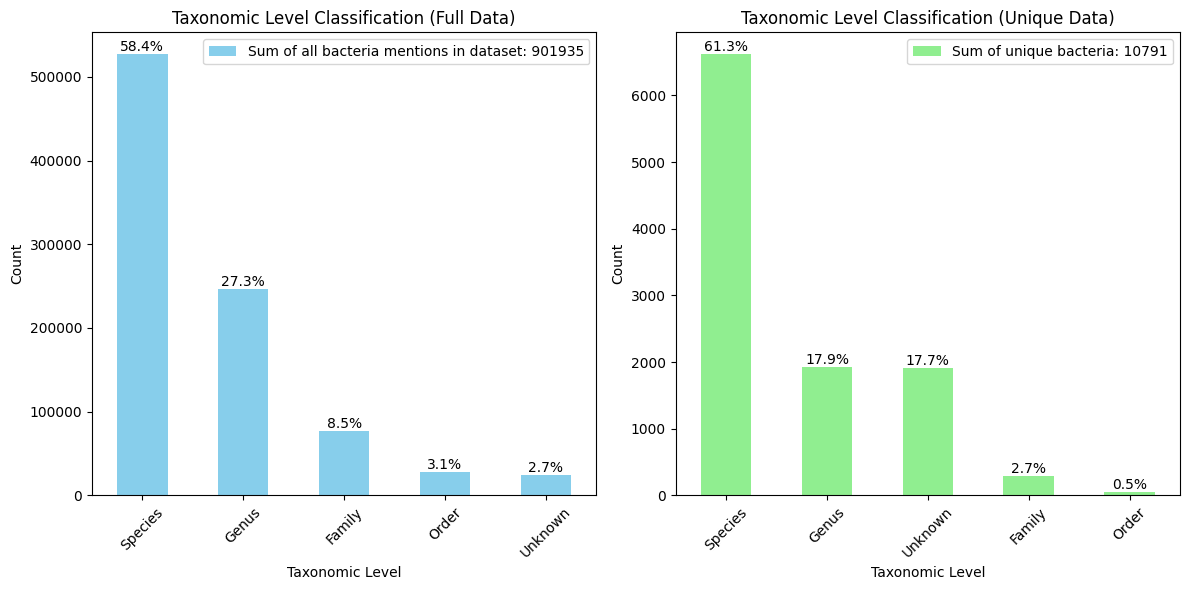

In [5]:
import pandas as pd

# Sample data
#data = pd.Series(['Escherichia coli', 'Escherichia', 'Enterobacteriaceae', 'Enterobacteriales'])


def classify_taxonomic_level(entry):
    if pd.isna(entry):  # Check for missing values (None, NaN, NA)
        return 'Unknown'
    words = entry.split()
    
    if len(words) == 2:
        if words[1].lower() in ['sp.', 'spp.']:
            return 'Genus'
        else:
            return 'Species'
    elif len(words) == 1:
        if entry.endswith('aceae'):
            return 'Family'
        elif entry.endswith('ales'):
            return 'Order'
        else:
            return 'Genus'
    return 'Unknown'

# Apply classification to the pandas series
data_classified = data.apply(classify_taxonomic_level)
category_counts = data_classified.value_counts()

unique_data = pd.Series(data.unique())  # Get unique values from the data
unique_classified = unique_data.apply(classify_taxonomic_level)
unique_category_counts = unique_classified.value_counts()

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for the full data series
category_counts.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Taxonomic Level Classification (Full Data)')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Taxonomic Level')
axes[0].tick_params(axis='x', rotation=45)
# Add percentage labels on top of the bars

category_percentages = (category_counts / category_counts.sum()) * 100

for container in axes[0].containers:
    axes[0].bar_label(container, labels=[f'{p:.1f}%' for p in category_percentages])
axes[0].legend([f'Sum of all bacteria mentions in dataset: {category_counts.sum()}'], loc='upper right')



# Plot for the unique values
unique_category_counts.plot(kind='bar', color='lightgreen', ax=axes[1])
axes[1].set_title('Taxonomic Level Classification (Unique Data)')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Taxonomic Level')
axes[1].tick_params(axis='x', rotation=45)
unique_category_percentages = (unique_category_counts / unique_category_counts.sum()) * 100

for container in axes[1].containers:
    axes[1].bar_label(container, labels=[f'{p:.1f}%' for p in unique_category_percentages])
axes[1].legend([f'Sum of unique bacteria: {unique_category_counts.sum()}'], loc='upper right')



plt.tight_layout()
plt.show()

In [6]:
data_classified

0          Genus
1          Genus
2          Genus
3         Family
4          Genus
          ...   
66818    Species
66819    Species
66820    Species
66821    Species
66822    Species
Name: Host, Length: 901935, dtype: object

In [7]:
data

0                      Gemmiger
1                     Neisseria
2                             -
3               Lachnospiraceae
4               Bifidobacterium
                  ...          
66818    Listeria monocytogenes
66819    Listeria monocytogenes
66820    Listeria monocytogenes
66821    Listeria monocytogenes
66822    Listeria monocytogenes
Name: Host, Length: 901935, dtype: string

In [8]:
# Assuming you have the Series data and data_classified defined
data_classified.name = 'Level'
hosts = pd.concat([data, data_classified], axis=1)
hosts

,Host,Level
0,Gemmiger,Genus
1,Neisseria,Genus
2,-,Genus
3,Lachnospiraceae,Family
4,Bifidobacterium,Genus
...,...,...
66818,Listeria monocytogenes,Species
66819,Listeria monocytogenes,Species
66820,Listeria monocytogenes,Species
66821,Listeria monocytogenes,Species


In [9]:
hosts = hosts.dropna()
hosts

,Host,Level
0,Gemmiger,Genus
1,Neisseria,Genus
2,-,Genus
3,Lachnospiraceae,Family
4,Bifidobacterium,Genus
...,...,...
66818,Listeria monocytogenes,Species
66819,Listeria monocytogenes,Species
66820,Listeria monocytogenes,Species
66821,Listeria monocytogenes,Species


In [10]:
import pandas as pd
from ete3 import NCBITaxa

# Initialize the NCBI taxonomy instance
ncbi = NCBITaxa()

# Example 'hosts' DataFrame (replace with your actual DataFrame)
# hosts = pd.DataFrame({'Host': ["Escherichia coli", "Bacillus subtilis", "Staphylococcus aureus"]})
hosts = hosts.copy()  # Use .copy() to avoid SettingWithCopyWarning

# Fetch taxonomic IDs from names in one batch
bacteria_names = hosts['Host'].unique()  # Get unique names to reduce calls
name_to_taxid = ncbi.get_name_translator(bacteria_names)

# Define the taxonomic levels of interest
taxonomic_levels = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

# Create a DataFrame to hold taxonomic information
taxonomic_data = {level: [] for level in taxonomic_levels}

# For each name, retrieve the lineage information and store it in taxonomic_data
for name in bacteria_names:
    taxid_list = name_to_taxid.get(name)
    if taxid_list:  # Check if the name exists in the translation
        lineage = ncbi.get_lineage(taxid_list[0])  # Fetch the lineage for the first taxon ID
        names = ncbi.get_taxid_translator(lineage)  # Get the names for the taxonomic IDs
        ranks = ncbi.get_rank(lineage)  # Get the ranks (species, genus, family, etc.)

        # Populate taxonomic data for the name
        for level in taxonomic_levels:
            taxonomic_data[level].append(names.get(next((tid for tid, r in ranks.items() if r == level), None), None))
    else:
        for level in taxonomic_levels:
            taxonomic_data[level].append(None)

# Convert the taxonomic data dictionary to a DataFrame
taxonomic_df = pd.DataFrame(taxonomic_data)


# Display the updated DataFrame with taxonomic columns
taxonomic_df


,superkingdom,phylum,class,order,family,genus,species
0,Bacteria,Bacillota,Clostridia,Eubacteriales,None,Gemmiger,None
1,Bacteria,Pseudomonadota,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,None
2,None,None,None,None,None,None,None
3,Bacteria,Bacillota,Clostridia,Lachnospirales,Lachnospiraceae,None,None
4,Bacteria,Actinomycetota,Actinomycetes,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,None
...,...,...,...,...,...,...,...
10785,Bacteria,Bacteroidota,Sphingobacteriia,Sphingobacteriales,Sphingobacteriaceae,Arcticibacter,Arcticibacter pallidicorallinus
10786,Bacteria,Bacillota,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,Massilimicrobiota,Massilimicrobiota sp.
10787,Bacteria,Bacteroidota,Cytophagia,Cytophagales,Hymenobacteraceae,Pontibacter,Pontibacter ummariensis
10788,Bacteria,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus sp. KBS0812


In [11]:
# Count the number of rows where 'Superkingdom' is 'none'
rows_to_remove = taxonomic_df[taxonomic_df['superkingdom'] != 'Bacteria'].shape[0]

# Remove rows where 'Superkingdom' is 'none'
taxonomic_df = taxonomic_df[taxonomic_df['superkingdom'] == 'Bacteria']

# Display the number of removed rows
print(f"Number of removed rows: {rows_to_remove}")

# Optionally, display the updated DataFrame
taxonomic_df

Number of removed rows: 4424


,superkingdom,phylum,class,order,family,genus,species
0,Bacteria,Bacillota,Clostridia,Eubacteriales,None,Gemmiger,None
1,Bacteria,Pseudomonadota,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,None
3,Bacteria,Bacillota,Clostridia,Lachnospirales,Lachnospiraceae,None,None
4,Bacteria,Actinomycetota,Actinomycetes,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,None
5,Bacteria,Bacillota,Clostridia,Eubacteriales,Oscillospiraceae,Faecalibacterium,None
...,...,...,...,...,...,...,...
10785,Bacteria,Bacteroidota,Sphingobacteriia,Sphingobacteriales,Sphingobacteriaceae,Arcticibacter,Arcticibacter pallidicorallinus
10786,Bacteria,Bacillota,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,Massilimicrobiota,Massilimicrobiota sp.
10787,Bacteria,Bacteroidota,Cytophagia,Cytophagales,Hymenobacteraceae,Pontibacter,Pontibacter ummariensis
10788,Bacteria,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus sp. KBS0812


In [12]:
print('n. of entries where we have the species: ')
print(taxonomic_df.shape[0] - (taxonomic_df['species'].isna().sum()))
perc = ((taxonomic_df.shape[0] - (taxonomic_df['species'].isna().sum())) / taxonomic_df.shape[0])*100
print(f'{perc} %')

n. of entries where we have the species: 
5108
80.2387684574301 %


In [16]:
taxonomic_df['species'][taxonomic_df['species'].isna() == 0].to_csv("bacteria_species.csv")

In [41]:
taxonomic_df.head()

,superkingdom,phylum,class,order,family,genus,species
0,Bacteria,Bacillota,Clostridia,Eubacteriales,None,Gemmiger,None
1,Bacteria,Pseudomonadota,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,None
3,Bacteria,Bacillota,Clostridia,Lachnospirales,Lachnospiraceae,None,None
4,Bacteria,Actinomycetota,Actinomycetes,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,None
5,Bacteria,Bacillota,Clostridia,Eubacteriales,Oscillospiraceae,Faecalibacterium,None


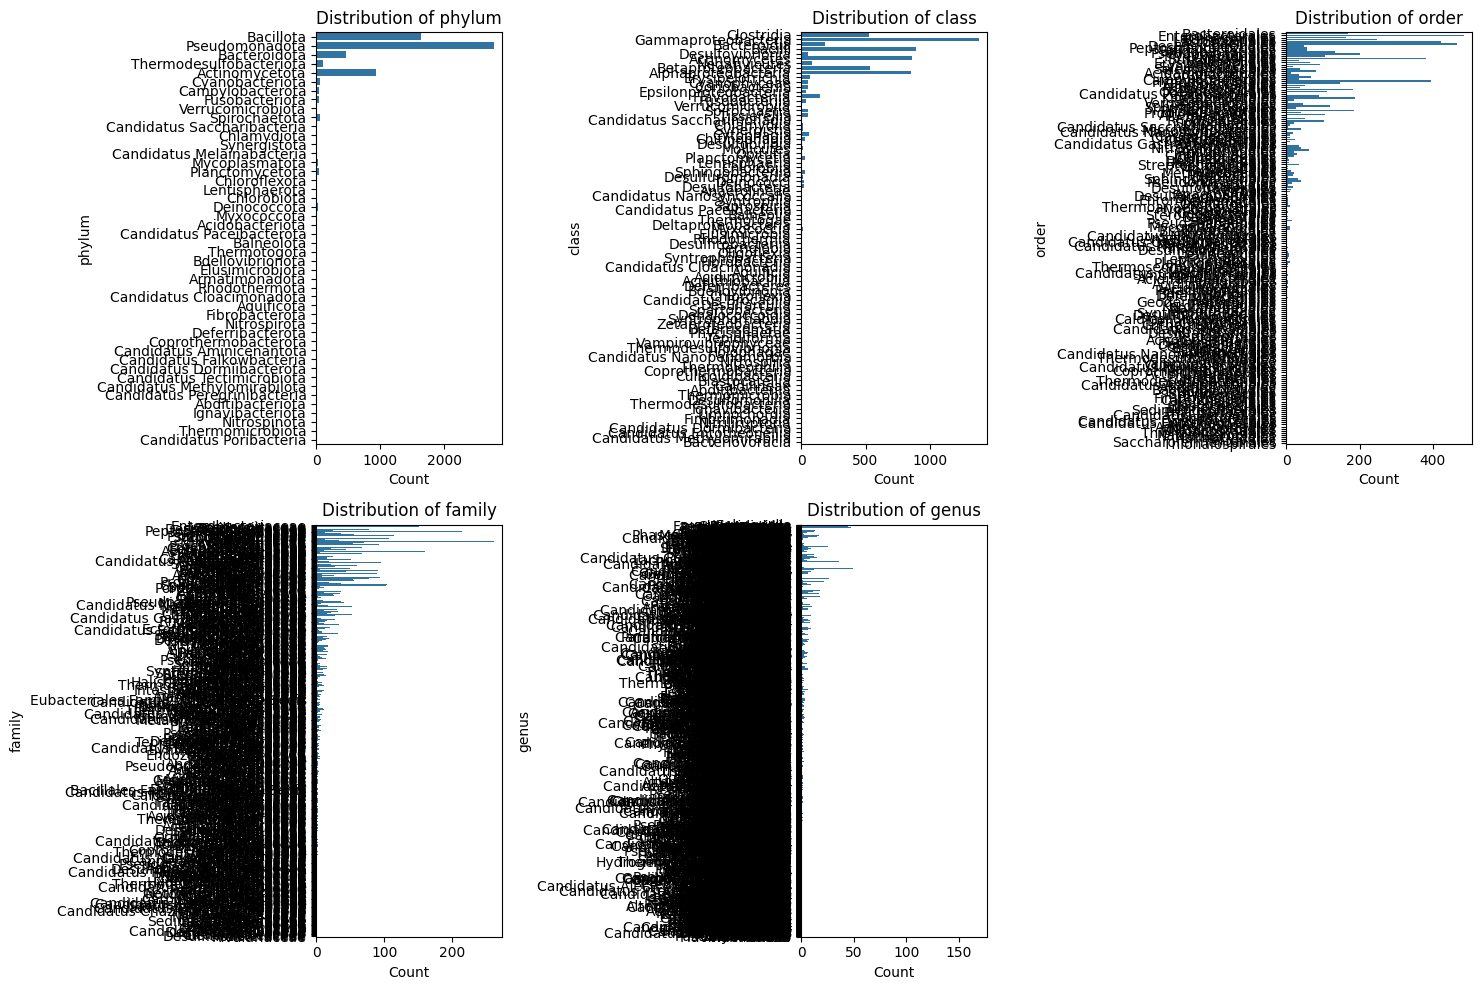

2024-10-09 11:51:00,534 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1308s; attempting restart: <WorkerState 'tcp://127.0.0.1:57145', name: 0, status: running, memory: 0, processing: 0>
2024-10-09 11:51:00,535 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1308s; attempting restart: <WorkerState 'tcp://127.0.0.1:57146', name: 3, status: running, memory: 0, processing: 0>
2024-10-09 11:51:00,536 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1308s; attempting restart: <WorkerState 'tcp://127.0.0.1:57147', name: 1, status: running, memory: 0, processing: 0>
2024-10-09 11:51:00,536 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1308s; attempting restart: <WorkerState 'tcp://127.0.0.1:57150', name: 2, status: running, memory: 0, processing: 0>
2024-10-09 11:51:01,784 - distributed.nanny - WARNING - Restarting worker
2024-10-09 11:51:01,800 - distributed.nanny - WARNING - Restarting worker
2024-10-09 11:51:01,

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame (replace this with your actual DataFrame)
# hosts = pd.DataFrame({...})  # Ensure hosts DataFrame contains ['phylum', 'class', 'order', 'family', 'genus']

# Define the taxonomic levels of interest
features = ['phylum', 'class', 'order', 'family', 'genus']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through the features to create a subplot for each
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns of subplots
    sns.countplot(data=taxonomic_df, y=feature, order=hosts[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)

plt.tight_layout()  # Adjusts the layout to prevent overlap
plt.savefig('Host_balance_unique_data.tif', format='TIFF')
plt.show()


In [47]:
# Ensure 'Host' is of the same type as taxonomic_df index
hosts['Host'] = hosts['Host'].astype(str)

# Reset the index of the taxonomic_df to merge on 'Host'
taxonomic_df['Host'] = bacteria_names

# Merge the original DataFrame with the taxonomic information
hosts = pd.merge(hosts, taxonomic_df, on='Host', how='left')

# Display the updated DataFrame with taxonomic columns
hosts


,Host,Level,superkingdom,phylum,class,order,family,genus,species
0,Gemmiger,Genus,Bacteria,Bacillota,Clostridia,Eubacteriales,None,Gemmiger,None
1,Neisseria,Genus,Bacteria,Pseudomonadota,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,None
2,-,Genus,None,None,None,None,None,None,None
3,Lachnospiraceae,Family,Bacteria,Bacillota,Clostridia,Lachnospirales,Lachnospiraceae,None,None
4,Bifidobacterium,Genus,Bacteria,Actinomycetota,Actinomycetes,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,None
...,...,...,...,...,...,...,...,...,...
901917,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes
901918,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes
901919,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes
901920,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes


In [48]:
hosts

,Host,Level,superkingdom,phylum,class,order,family,genus,species
0,Gemmiger,Genus,Bacteria,Bacillota,Clostridia,Eubacteriales,None,Gemmiger,None
1,Neisseria,Genus,Bacteria,Pseudomonadota,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,None
2,-,Genus,None,None,None,None,None,None,None
3,Lachnospiraceae,Family,Bacteria,Bacillota,Clostridia,Lachnospirales,Lachnospiraceae,None,None
4,Bifidobacterium,Genus,Bacteria,Actinomycetota,Actinomycetes,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,None
...,...,...,...,...,...,...,...,...,...
901917,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes
901918,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes
901919,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes
901920,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes


In [49]:
# Count the number of rows where 'Superkingdom' is 'none'
rows_to_remove = hosts[hosts['superkingdom'] != 'Bacteria'].shape[0]

# Remove rows where 'Superkingdom' is 'none'
hosts = hosts[hosts['superkingdom'] == 'Bacteria']

# Display the number of removed rows
print(f"Number of removed rows: {rows_to_remove}")

# Optionally, display the updated DataFrame
hosts

Number of removed rows: 157245


,Host,Level,superkingdom,phylum,class,order,family,genus,species
0,Gemmiger,Genus,Bacteria,Bacillota,Clostridia,Eubacteriales,None,Gemmiger,None
1,Neisseria,Genus,Bacteria,Pseudomonadota,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,None
3,Lachnospiraceae,Family,Bacteria,Bacillota,Clostridia,Lachnospirales,Lachnospiraceae,None,None
4,Bifidobacterium,Genus,Bacteria,Actinomycetota,Actinomycetes,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,None
5,Faecalibacterium,Genus,Bacteria,Bacillota,Clostridia,Eubacteriales,Oscillospiraceae,Faecalibacterium,None
...,...,...,...,...,...,...,...,...,...
901917,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes
901918,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes
901919,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes
901920,Listeria monocytogenes,Species,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes


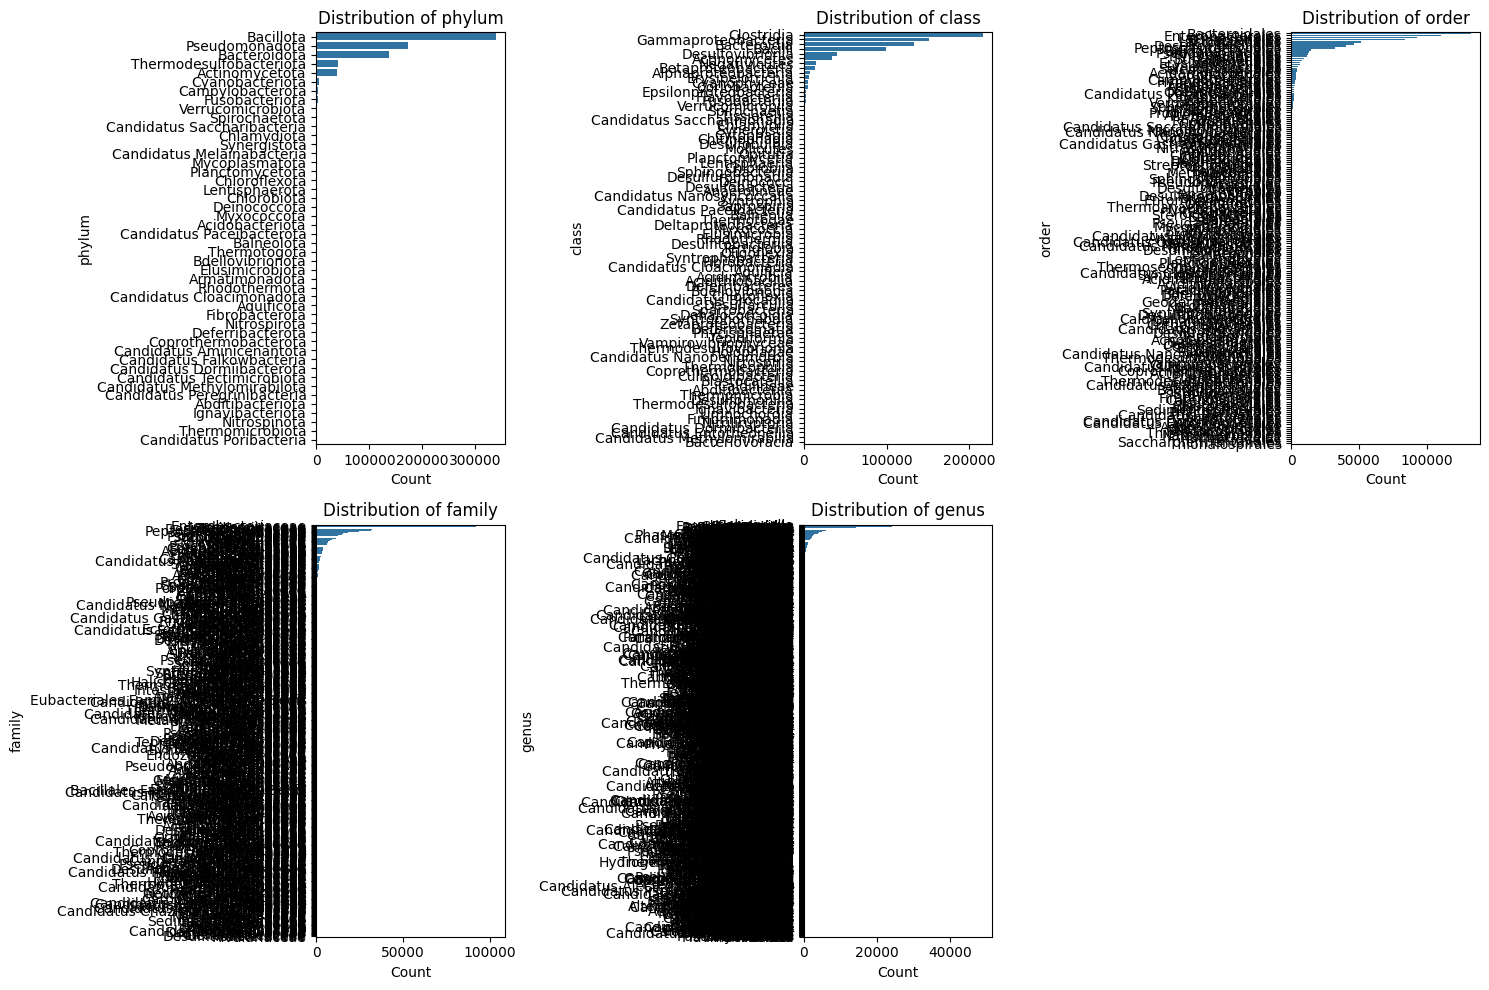

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame (replace this with your actual DataFrame)
# hosts = pd.DataFrame({...})  # Ensure hosts DataFrame contains ['phylum', 'class', 'order', 'family', 'genus']

# Define the taxonomic levels of interest
features = ['phylum', 'class', 'order', 'family', 'genus']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through the features to create a subplot for each
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns of subplots
    sns.countplot(data=hosts, y=feature, order=hosts[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)

plt.tight_layout()  # Adjusts the layout to prevent overlap
plt.savefig('Host_balance_all_data.tif', format='TIFF')
plt.show()


In [12]:
hosts.iloc[0:5,:]['Host']


0           Gemmiger
1          Neisseria
2                  -
3    Lachnospiraceae
4    Bifidobacterium
Name: Host, dtype: string

In [18]:
from ete3 import NCBITaxa, Tree
from ete3 import TreeStyle

# Initialize NCBI taxonomy object
ncbi = NCBITaxa()

# Example list of species or genus names
#bacteria_names = ["Escherichia coli", "Bacillus subtilis", "Staphylococcus aureus"]

# Assuming `hosts['Host']` is the column containing the bacterial names

# Remove invalid names (e.g., NA, NaN, None)
bacteria_names = hosts['Host'].dropna()

# Further ensure all names are strings, filter out invalid entries
bacteria_names = bacteria_names[bacteria_names.apply(lambda x: isinstance(x, str))]

# Now call ncbi.get_name_translator() with the cleaned list of names
name_to_taxid = ncbi.get_name_translator(bacteria_names)

# Extract taxids
taxids = [taxid[0] for taxid in name_to_taxid.values()]

# Build a taxonomic tree using these taxids
tree = ncbi.get_topology(taxids)

# Check which leaves have numeric names (taxonomic IDs) and which have actual names
taxids = []
for leaf in tree.iter_leaves():
    try:
        taxid = int(leaf.name)  # Try to convert the leaf name to an integer (assuming it's a taxonomic ID)
        taxids.append(taxid)
    except ValueError:
        # If it's not an integer, it's already a name, so skip it
        pass

# Translate taxonomic IDs to names
taxid_to_name = ncbi.get_taxid_translator(taxids)

# Update the leaf nodes in the tree with the corresponding names, where applicable
for leaf in tree.iter_leaves():
    try:
        taxid = int(leaf.name)  # Try to convert the leaf name to a taxonomic ID
        leaf.name = taxid_to_name.get(taxid, leaf.name)  # Replace ID with name, or leave as is if not found
    except ValueError:
        # If it's already a name, no need to change it
        pass


# Create a tree style for visualization
ts = TreeStyle()
ts.mode = "c"  # Circular layout, you can change it to "r" for rectangular
ts.show_leaf_name = False  # Show the leaf names (bacteria names)


# Display the tree plot
#tree.show(tree_style=ts)
#tree.render("large_tree.png", w=1000, units="px", tree_style=ts)
tree.render("large_tree.png", units="px", tree_style=ts)


{'nodes': [[16.863636363636363,
   14459.1484375,
   19.863636363636363,
   14462.1484375,
   0,
   None],
  [35.22727272727273, 12864.296875, 38.22727272727273, 12867.296875, 1, None],
  [53.59090909090909, 9695.59375, 56.59090909090909, 9698.59375, 2, None],
  [71.95454545454545, 3463.1875, 74.95454545454545, 3466.1875, 3, None],
  [90.31818181818181, 1624.375, 93.31818181818181, 1627.375, 4, None],
  [108.68181818181817, 46.75, 111.68181818181817, 49.75, 5, None],
  [127.04545454545453, 20.5, 130.04545454545453, 23.5, 6, None],
  [145.4090909090909, 10.0, 148.4090909090909, 13.0, 7, None],
  [145.4090909090909, 31.0, 148.4090909090909, 34.0, 8, None],
  [127.04545454545453, 52.0, 130.04545454545453, 55.0, 9, None],
  [127.04545454545453, 73.0, 130.04545454545453, 76.0, 10, None],
  [108.68181818181817, 172.75, 111.68181818181817, 175.75, 11, None],
  [127.04545454545453, 104.5, 130.04545454545453, 107.5, 12, None],
  [145.40909090909088, 94.0, 148.40909090909088, 97.0, 13, None],
  

In [20]:
taxids

[106633,
 406099,
 2035712,
 1056,
 1172191,
 28108,
 267375,
 161398,
 53249,
 24,
 50422,
 280483,
 553,
 549,
 79967,
 552,
 338565,
 558,
 2100764,
 1335483,
 61645,
 550,
 158836,
 69218,
 90371,
 594,
 599,
 67825,
 57706,
 546,
 498388,
 316385,
 316407,
 331112,
 1884818,
 571,
 573,
 244366,
 576,
 160674,
 621,
 623,
 624,
 1903434,
 82976,
 28141,
 413502,
 83654,
 61647,
 1898429,
 67780,
 636,
 569,
 554,
 29471,
 1089444,
 1914291,
 584,
 587,
 588,
 126385,
 626,
 29487,
 582,
 615,
 630,
 632,
 633,
 29484,
 2716544,
 82978,
 82980,
 63612,
 45247,
 933,
 119864,
 1904862,
 1926584,
 504090,
 2745,
 574347,
 59753,
 339,
 347,
 56448,
 56460,
 346,
 40324,
 83618,
 2371,
 75309,
 416,
 1808977,
 1295378,
 129577,
 644,
 645,
 651,
 654,
 647,
 347533,
 866,
 674963,
 83770,
 1654787,
 294,
 29442,
 287,
 303,
 587753,
 317,
 352,
 1960084,
 75985,
 1755672,
 713,
 727,
 747,
 109471,
 697331,
 416916,
 476528,
 731,
 738,
 51366,
 55601,
 663,
 669,
 670,
 666,
 672,
 2

In [25]:
taxid_to_name

{1: 'root',
 2: 'Bacteria',
 22: 'Shewanella',
 24: 'Shewanella putrefaciens',
 29: 'Myxococcales',
 31: 'Myxococcaceae',
 32: 'Myxococcus',
 34: 'Myxococcus xanthus',
 75: 'Caulobacter',
 105: 'Runella',
 107: 'Spirosoma',
 112: 'Planctomycetales',
 126: 'Planctomycetaceae',
 133: 'Methylocystis',
 136: 'Spirochaetales',
 137: 'Spirochaetaceae',
 157: 'Treponema',
 170: 'Leptospiraceae',
 171: 'Leptospira',
 173: 'Leptospira interrogans',
 191: 'Azospirillum',
 192: 'Azospirillum brasilense',
 194: 'Campylobacter',
 195: 'Campylobacter coli',
 196: 'Campylobacter fetus',
 197: 'Campylobacter jejuni',
 199: 'Campylobacter concisus',
 205: 'Campylobacter sp.',
 209: 'Helicobacter',
 210: 'Helicobacter pylori',
 213: 'Helicobacter cinaedi',
 222: 'Achromobacter',
 226: 'Alteromonas',
 234: 'Brucella',
 235: 'Brucella abortus',
 237: 'Flavobacterium',
 239: 'Flavobacterium sp.',
 265: 'Paracoccus',
 270: 'Thermus',
 274: 'Thermus thermophilus',
 283: 'Comamonas',
 286: 'Pseudomonas',
 287

Taxonomic Coverage by Phylum:
Pseudomonadota: 253 species
Actinomycetota: 84 species
Bacillota: 270 species
Mycoplasmatota: 5 species
Chloroflexota: 3 species
Deinococcota: 3 species
Cyanobacteriota: 12 species
Bacteroidota: 63 species
Chlorobiota: 2 species
Fibrobacterota: 1 species
Thermodesulfobacteriota: 5 species
Spirochaetota: 11 species
Bdellovibrionota: 2 species
Verrucomicrobiota: 2 species
Planctomycetota: 4 species
Lentisphaerota: 1 species
Chlamydiota: 3 species
Nitrospirota: 1 species
Campylobacterota: 10 species
Candidatus Saccharibacteria: 4 species
Candidatus Peregrinibacteria: 1 species
Candidatus Falkowbacteria: 1 species
Acidobacteriota: 1 species
Fusobacteriota: 8 species
Synergistota: 4 species
Myxococcota: 1 species
Mollusca: 1 species
Arthropoda: 1 species
Discosea: 1 species
Nitrososphaerota: 1 species


<Figure size 1000x600 with 0 Axes>

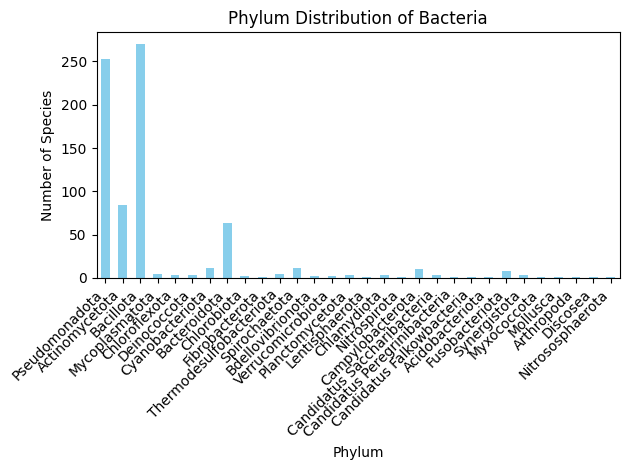

In [24]:
# ---- Taxonomic Coverage ----
# Retrieve full lineages for each taxid (returns a list of taxonomic IDs)
lineages = ncbi.get_lineage_translator(taxids)

# Retrieve the ranks of each taxonomic ID in the lineages
all_taxids_in_lineage = set([taxid for lineage in lineages.values() for taxid in lineage])
ranks = ncbi.get_rank(all_taxids_in_lineage)

# Retrieve the names for each taxonomic ID
taxid_to_name = ncbi.get_taxid_translator(all_taxids_in_lineage)

# Create a dictionary to store the count of species in each phylum
phylum_counts = {}

# Iterate over each taxid and its lineage
for taxid in taxids:
    lineage = lineages.get(taxid, [])
    for ancestor_taxid in lineage:
        rank = ranks.get(ancestor_taxid, "")
        if rank == "phylum":  # Change this to 'class', 'order', etc., as needed
            phylum_name = taxid_to_name.get(ancestor_taxid, "Unknown")
            phylum_counts[phylum_name] = phylum_counts.get(phylum_name, 0) + 1
            break  # Exit after finding the first phylum (or desired rank)

# Print the taxonomic coverage
print("Taxonomic Coverage by Phylum:")
for phylum, count in phylum_counts.items():
    print(f"{phylum}: {count} classes")

# Convert the dictionary into a pandas DataFrame for easier plotting
phylum_df = pd.DataFrame(list(phylum_counts.items()), columns=['Phylum', 'Count'])

# Plot the phylum distribution using a bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
phylum_df.plot(kind='bar', x='Phylum', y='Count', legend=False, color='skyblue')
plt.title('Phylum Distribution of Bacteria')
plt.xlabel('Phylum')
plt.ylabel('Number of Classes')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjusts layout to prevent label cut-off
plt.show()


In [23]:
type(phylum_counts)






dict

In [15]:
from ete3 import NCBITaxa

# Initialize the NCBI taxonomy instance
ncbi = NCBITaxa()

# Example list of species or genera names
#bacteria_names = ["Escherichia coli", "Bacillus subtilis", "Staphylococcus aureus"]
bacteria_names = hosts.iloc[0:5,:]['Host']


# Fetch taxonomic IDs from names
name_to_taxid = ncbi.get_name_translator(bacteria_names)

# For each taxon, retrieve the lineage information
for name, taxid in name_to_taxid.items():
    lineage = ncbi.get_lineage(taxid[0])  # Fetch the lineage for the first taxon ID
    names = ncbi.get_taxid_translator(lineage)  # Get the names for the taxonomic IDs
    ranks = ncbi.get_rank(lineage)  # Get the ranks (species, genus, family, etc.)
    
    print(f"Taxonomic lineage for {name}:")
    for taxid in lineage:
        print(f"{ranks[taxid]}: {names[taxid]}")
    print("\n")


Taxonomic lineage for Bifidobacterium:
no rank: root
no rank: cellular organisms
superkingdom: Bacteria
clade: Terrabacteria group
phylum: Actinomycetota
class: Actinomycetes
order: Bifidobacteriales
family: Bifidobacteriaceae
genus: Bifidobacterium


Taxonomic lineage for Gemmiger:
no rank: root
no rank: cellular organisms
superkingdom: Bacteria
clade: Terrabacteria group
phylum: Bacillota
class: Clostridia
order: Eubacteriales
no rank: Eubacteriales incertae sedis
genus: Gemmiger


Taxonomic lineage for Lachnospiraceae:
no rank: root
no rank: cellular organisms
superkingdom: Bacteria
clade: Terrabacteria group
phylum: Bacillota
class: Clostridia
order: Lachnospirales
family: Lachnospiraceae


Taxonomic lineage for Neisseria:
no rank: root
no rank: cellular organisms
superkingdom: Bacteria
phylum: Pseudomonadota
class: Betaproteobacteria
order: Neisseriales
family: Neisseriaceae
genus: Neisseria


